# Testing our three models

## Imports

In [12]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
import plotly.express as px
from IPython.display import display
from sklearn.linear_model import LinearRegression
from collections.abc import Callable
from prophet import Prophet
import xgboost as xgb

In [13]:
#############
# Needed to suppress prophet output
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)
#############

## Fetching data

In [14]:
df = pd.read_csv("../consumption_temp.csv")
# Convert dftypes
df["time"] = pd.to_datetime(df["time"])
df["consumption"] = pd.to_numeric(df["consumption"])
df["temperature"] = pd.to_numeric(df["temperature"])

## Time-series split cross validation evaluation criteria

In [15]:

def time_series_split_validation(df, model_callback: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]):
    print("Evaluating", model_callback.__name__)

    df = df.copy()

    ret = pd.DataFrame()
    forecasts = pd.DataFrame()

    num_days = 30

    for loc in df.location.unique():
        print("Evaluating location", loc)
        tdf = df[df.location == loc][:-22] # needs to eliminate the last day with only 22 hrs to get full day tests
        tscv = TimeSeriesSplit(n_splits=num_days, gap=14, test_size=24) # gap=14 eliminates hours 10-23 of day before forecast

        counter = 1
        print("Forecast progress", end="")
        for split_tuple in tscv.split(tdf):
            print(" " + str(counter), end="")
            counter+=1

            fcst = model_callback(tdf.iloc[split_tuple[0]], tdf.iloc[split_tuple[1]])
            
            mape = (abs(fcst.consumption - fcst.yhat) / fcst.consumption).mean() * 100
            mae = (abs(fcst.consumption - fcst.yhat)).mean()
            
            fcst_date = fcst.time.dt.date.iloc[0]

            ret = pd.concat([ret, pd.DataFrame(data={'location': loc, 'forecast_date': fcst_date, 'mape': mape, 'mae': mae}, index=[0])])
            forecasts = pd.concat([forecasts, fcst])
            
        print()

    return ret.reset_index(drop=True), forecasts.reset_index(drop=True)
            
            

## Model format

In [16]:
# all models will be in the following format
def naive_model(df, future):
    """ df and future already filtered by location """
    df = df.copy()
    future = future.copy()
    
    mean = df.consumption.mean()
    future['yhat'] = mean

    return future

In [17]:
for loc in df.location.unique():
    filtered_df = df[df.location == loc]
    fcst = naive_model(filtered_df.iloc[:-24], filtered_df.iloc[-24:])
    # display(fcst)
    # print(fcst.time.dt.date.iloc[0])

## Linear regression

In [18]:

def linear_model(df, future):
    df = df.copy()
    future = future.copy()
    
    model = LinearRegression()

    # Fit the model to the training data
    model.fit(df.temperature.values.reshape(-1, 1), df.consumption.values.reshape(-1, 1))

    # Make predictions on the test data
    y_pred = model.predict(future.temperature.values.reshape(-1, 1))
    future['yhat'] = y_pred

    return future

## Prophet

In [19]:

def prophet_model(df, future):
    df = df.copy()
    future = future.copy()
    
    model = Prophet()
    model.add_regressor('temperature')
    model.fit(df.rename(columns={'time': 'ds', 'consumption': 'y'}))

    # Make predictions on the test data
    y_pred = model.predict(future.rename(columns={'time': 'ds'})).yhat.values
    future['yhat'] = y_pred

    return future

## XGBoost

In [20]:

def xgboost_model(df, future):
    df = df.copy()
    future = future.copy()

    # creating time series features (chatgpt suggestions)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['day_of_week'] = df['time'].dt.dayofweek
    df['day_of_year'] = df['time'].dt.dayofyear
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    future['year'] = future['time'].dt.year
    future['month'] = future['time'].dt.month
    future['day'] = future['time'].dt.day
    future['hour'] = future['time'].dt.hour
    future['day_of_week'] = future['time'].dt.dayofweek
    future['day_of_year'] = future['time'].dt.dayofyear
    future['hour_sin'] = np.sin(2 * np.pi * future['hour'] / 24)
    future['hour_cos'] = np.cos(2 * np.pi * future['hour'] / 24)

    # Create and train an XGBoost model
    # Standard hyperparameters for prototyping, no gridsearch or similar
    model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:absoluteerror", #"reg:squarederror",
        random_state=42,
    )
    X = df[['temperature', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'hour_sin', 'hour_cos']]
    y = df['consumption']
    model.fit(X, y)

    # Make predictions on the test set
    X_test = future[['temperature', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'hour_sin', 'hour_cos']]
    y_pred = model.predict(X_test)

    future['yhat'] = y_pred

    return future[['time', 'location', 'consumption', 'temperature', 'yhat']]



## Evaluation

In [22]:
out = pd.DataFrame()
forecasts = pd.DataFrame()

return_values = []

for model_callback in [linear_model, prophet_model]:  # [naive_model, linear_model, prophet_model, xgboost_model]:
    model_name = model_callback.__name__
    ret, out_forecasts = time_series_split_validation(df, model_callback)
    return_values.append((ret, out_forecasts))
    ret = ret[['location', 'mae']]
    ret = ret.groupby('location').mean().reset_index()
    ret['model'] = model_name
    out_forecasts['model'] = model_name
    out = pd.concat([out, ret[['location', 'model', 'mae']]])


Evaluating linear_model
Evaluating location bergen
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location oslo
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location stavanger
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location tromsø
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location trondheim
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location helsingfors
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating prophet_model
Evaluating location bergen
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location oslo
Forecast progress 1 2 3 4 5 6 7 8 9

# Plot forecasts

Next model
Location:  bergen


C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['time'] = pd.to_datetime(location_data['time'])
C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data["temperature"] = -1*location_data["temperature"]


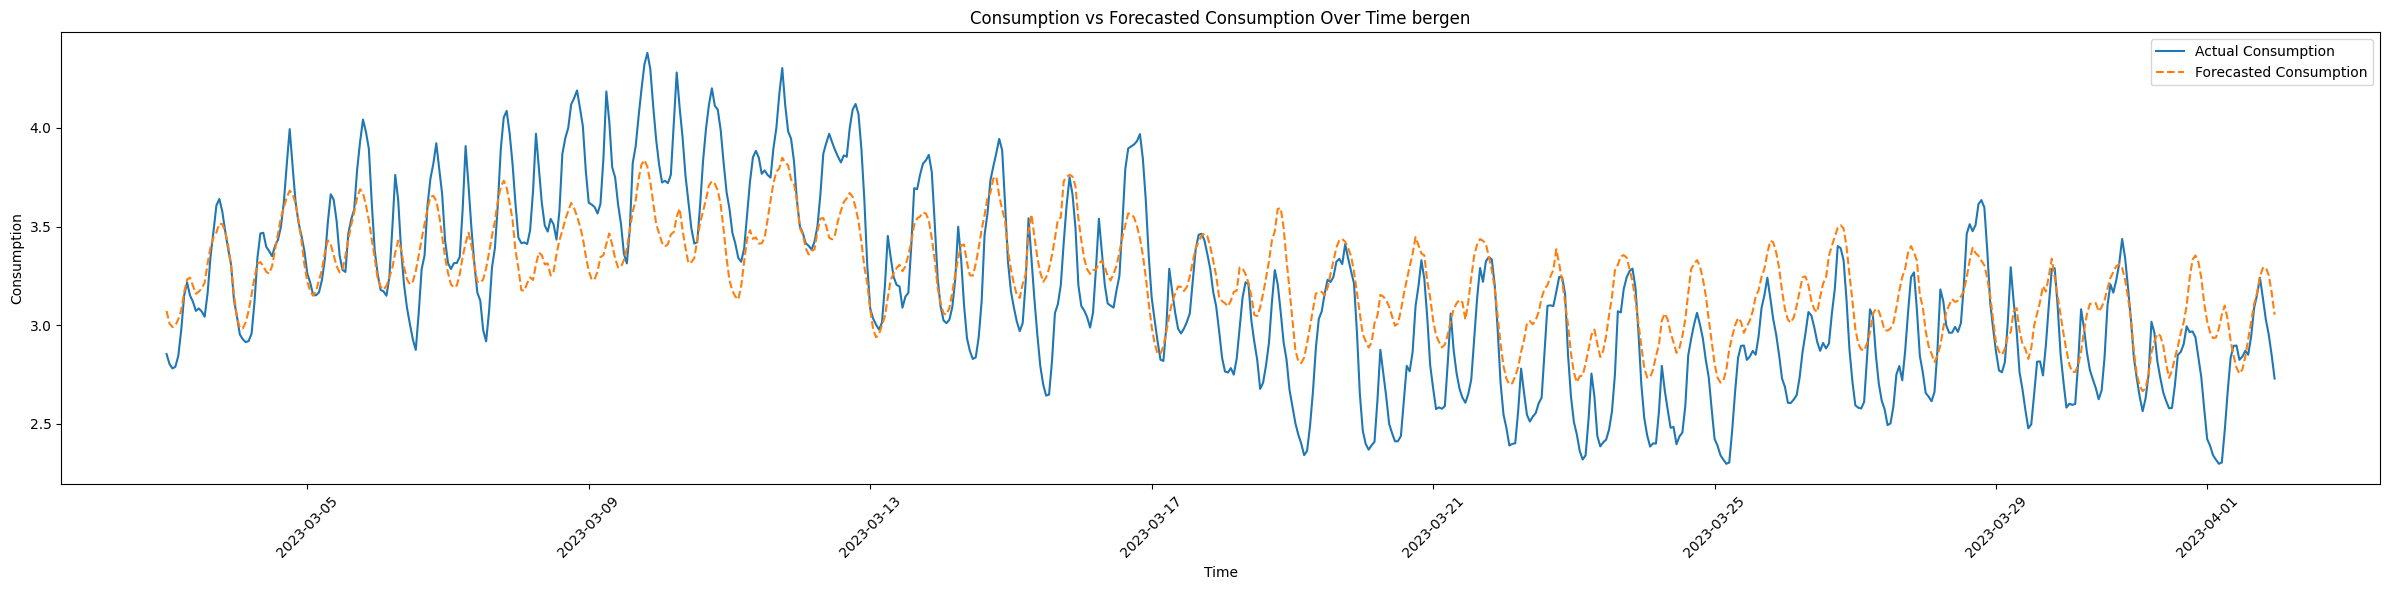

Location:  oslo


C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['time'] = pd.to_datetime(location_data['time'])
C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data["temperature"] = -1*location_data["temperature"]


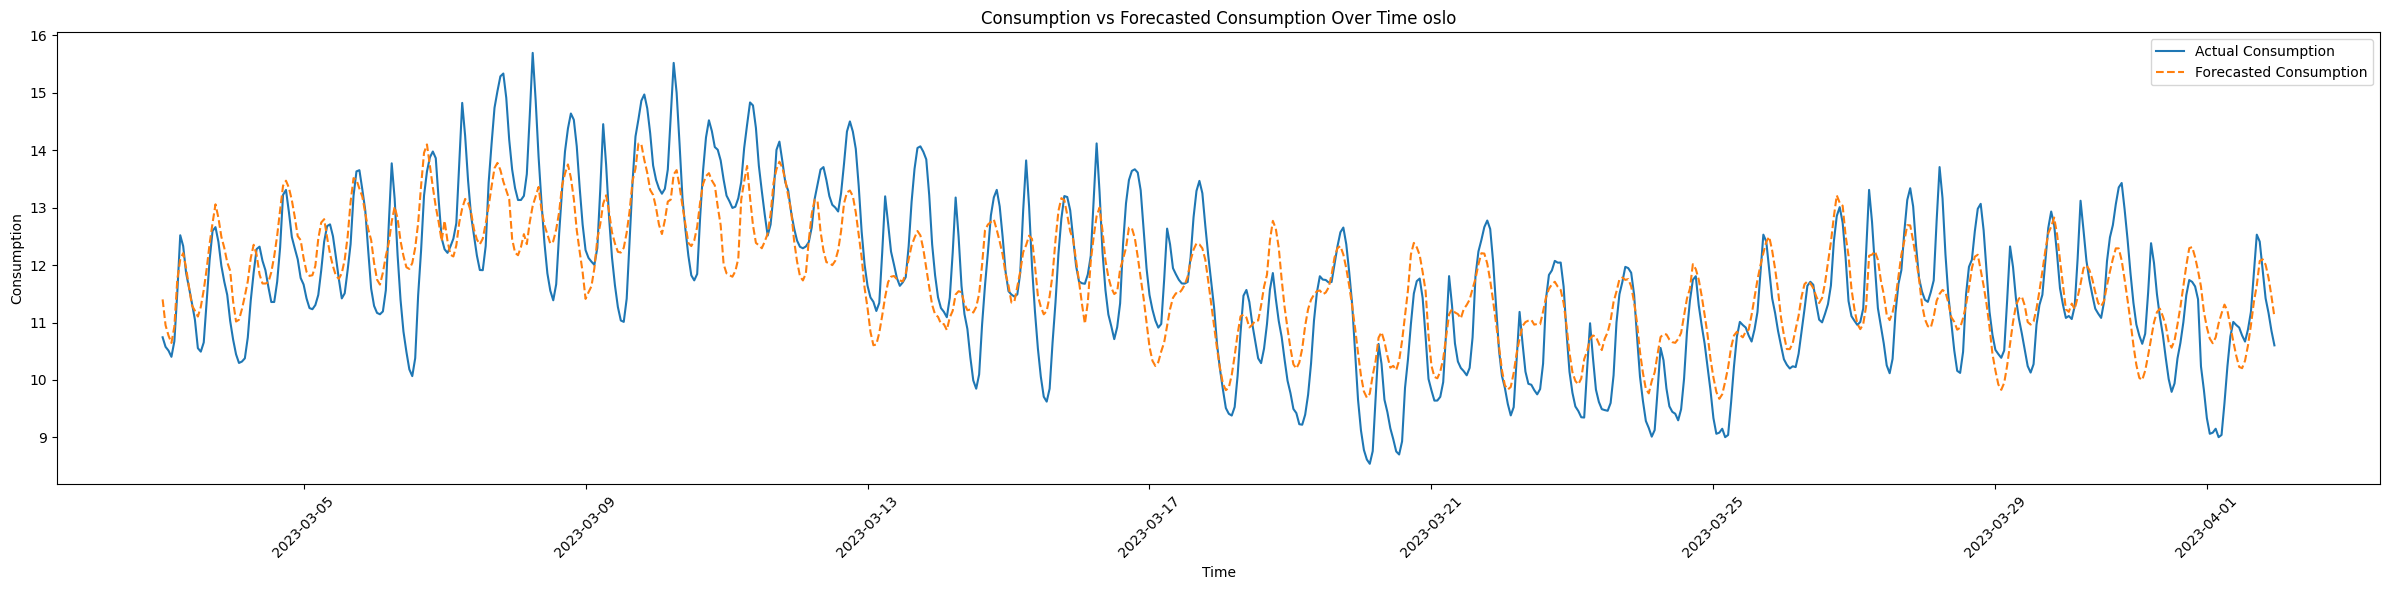

Location:  stavanger


C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['time'] = pd.to_datetime(location_data['time'])
C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data["temperature"] = -1*location_data["temperature"]


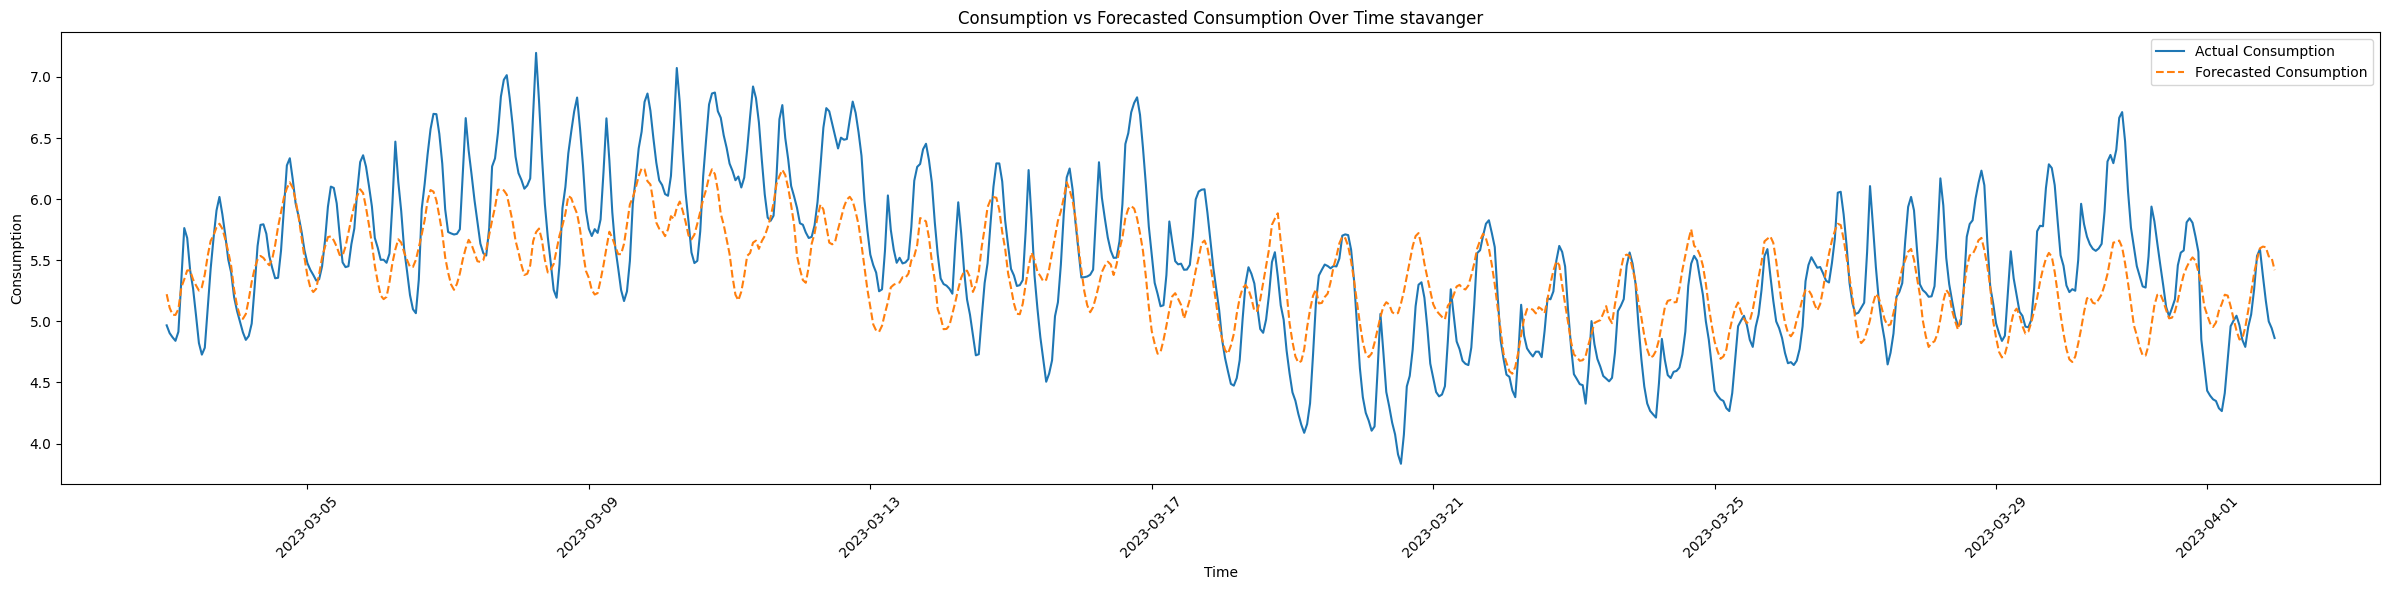

Location:  tromsø


C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['time'] = pd.to_datetime(location_data['time'])
C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data["temperature"] = -1*location_data["temperature"]


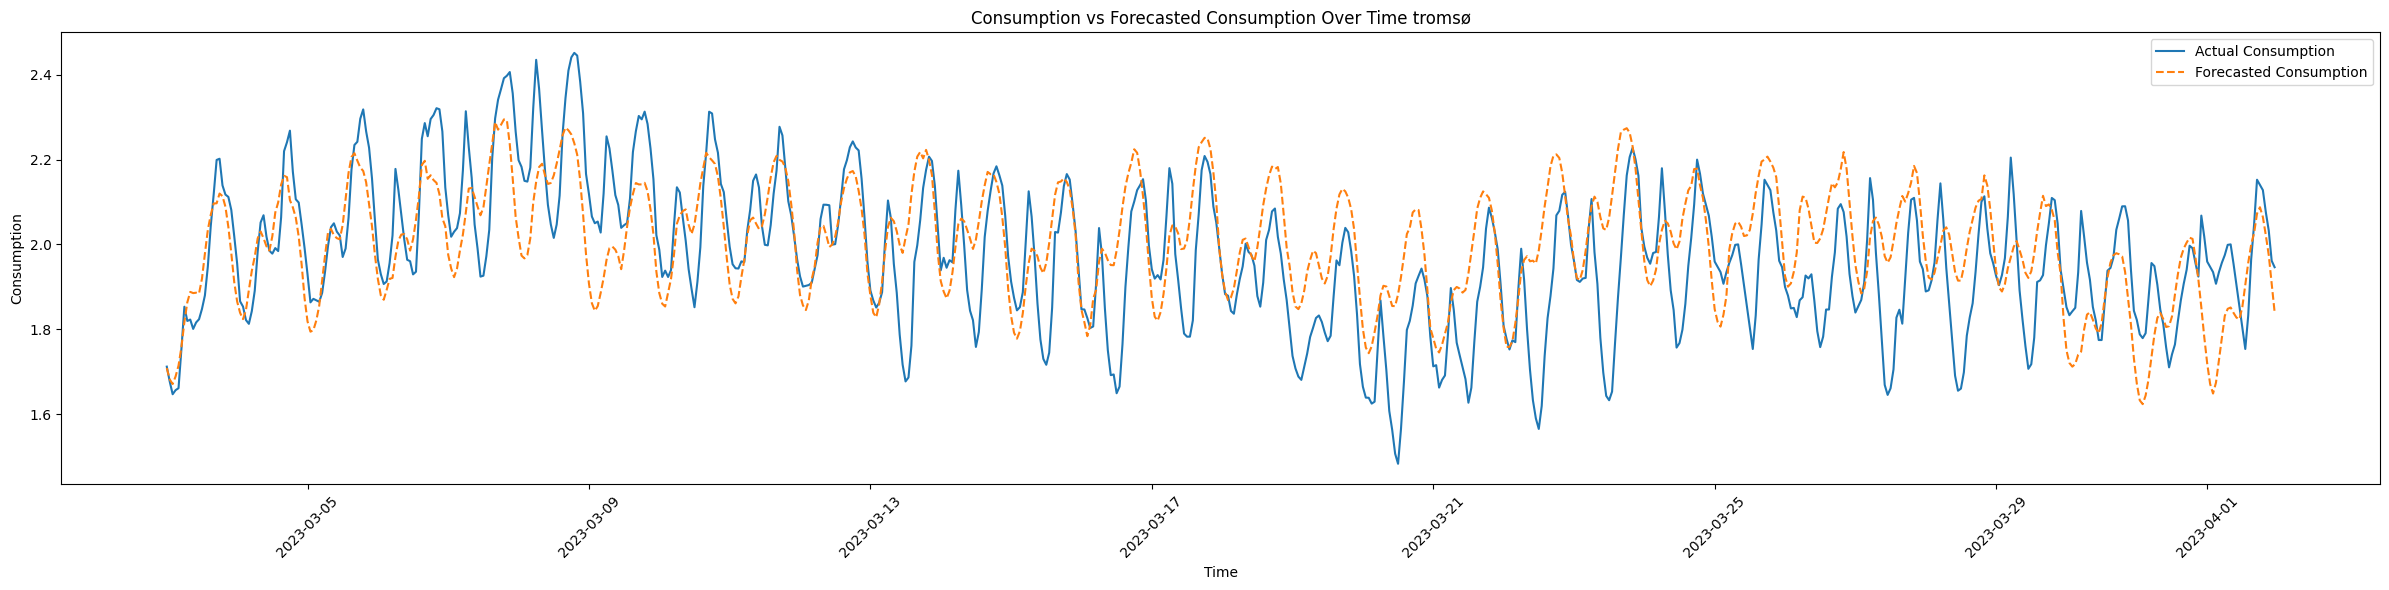

Location:  trondheim


C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['time'] = pd.to_datetime(location_data['time'])
C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data["temperature"] = -1*location_data["temperature"]


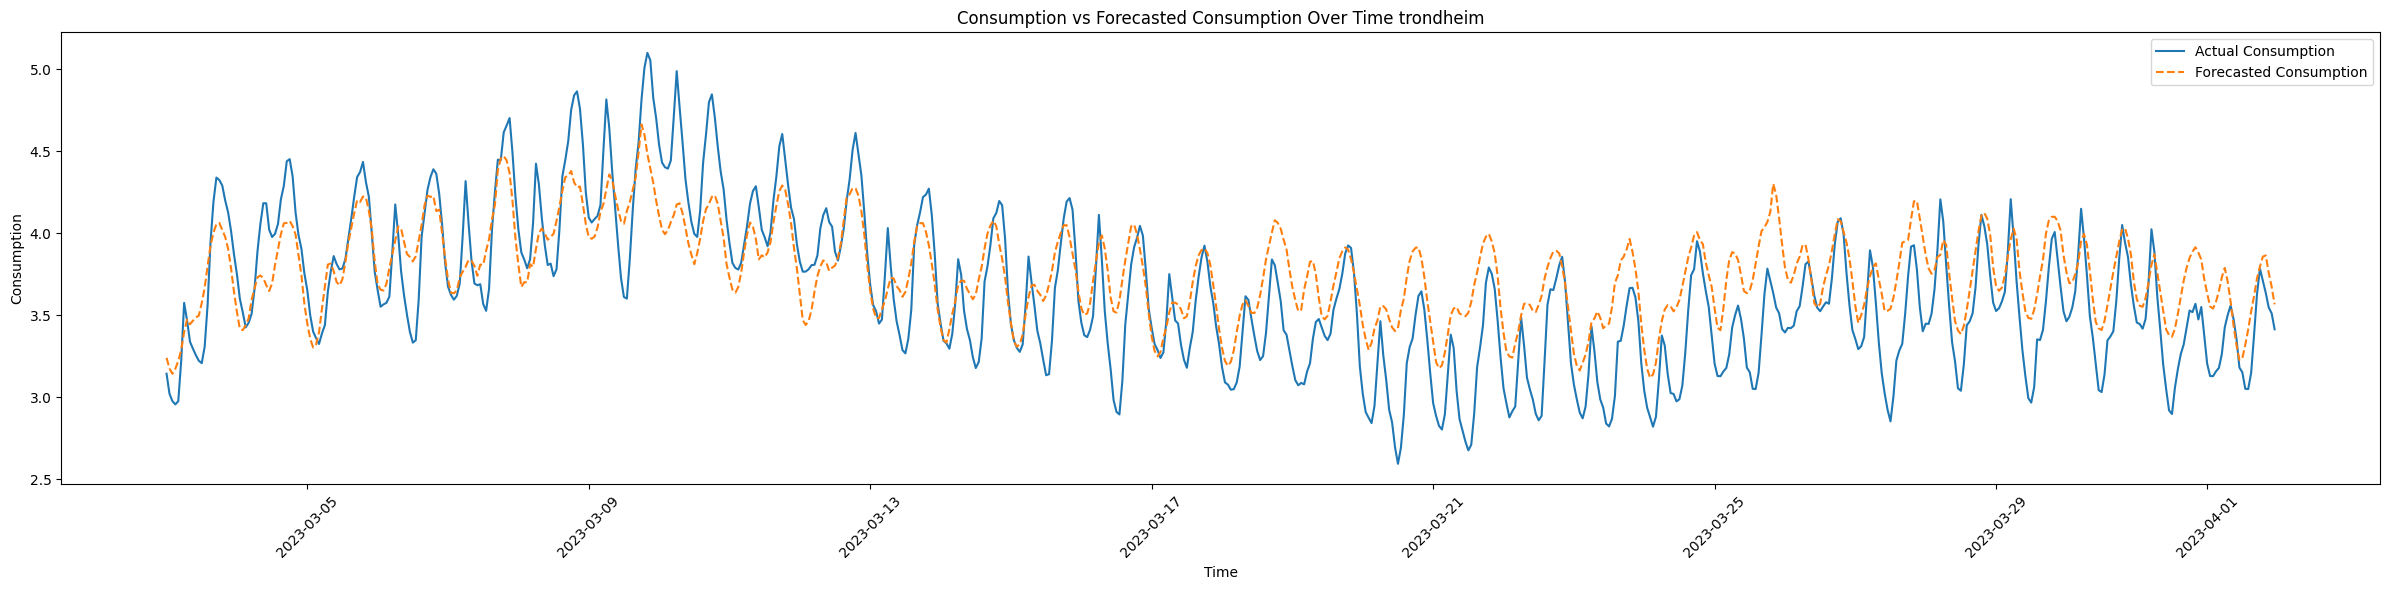

Location:  helsingfors


C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['time'] = pd.to_datetime(location_data['time'])
C:\Users\Bruker\AppData\Local\Temp\ipykernel_26984\1457588012.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data["temperature"] = -1*location_data["temperature"]


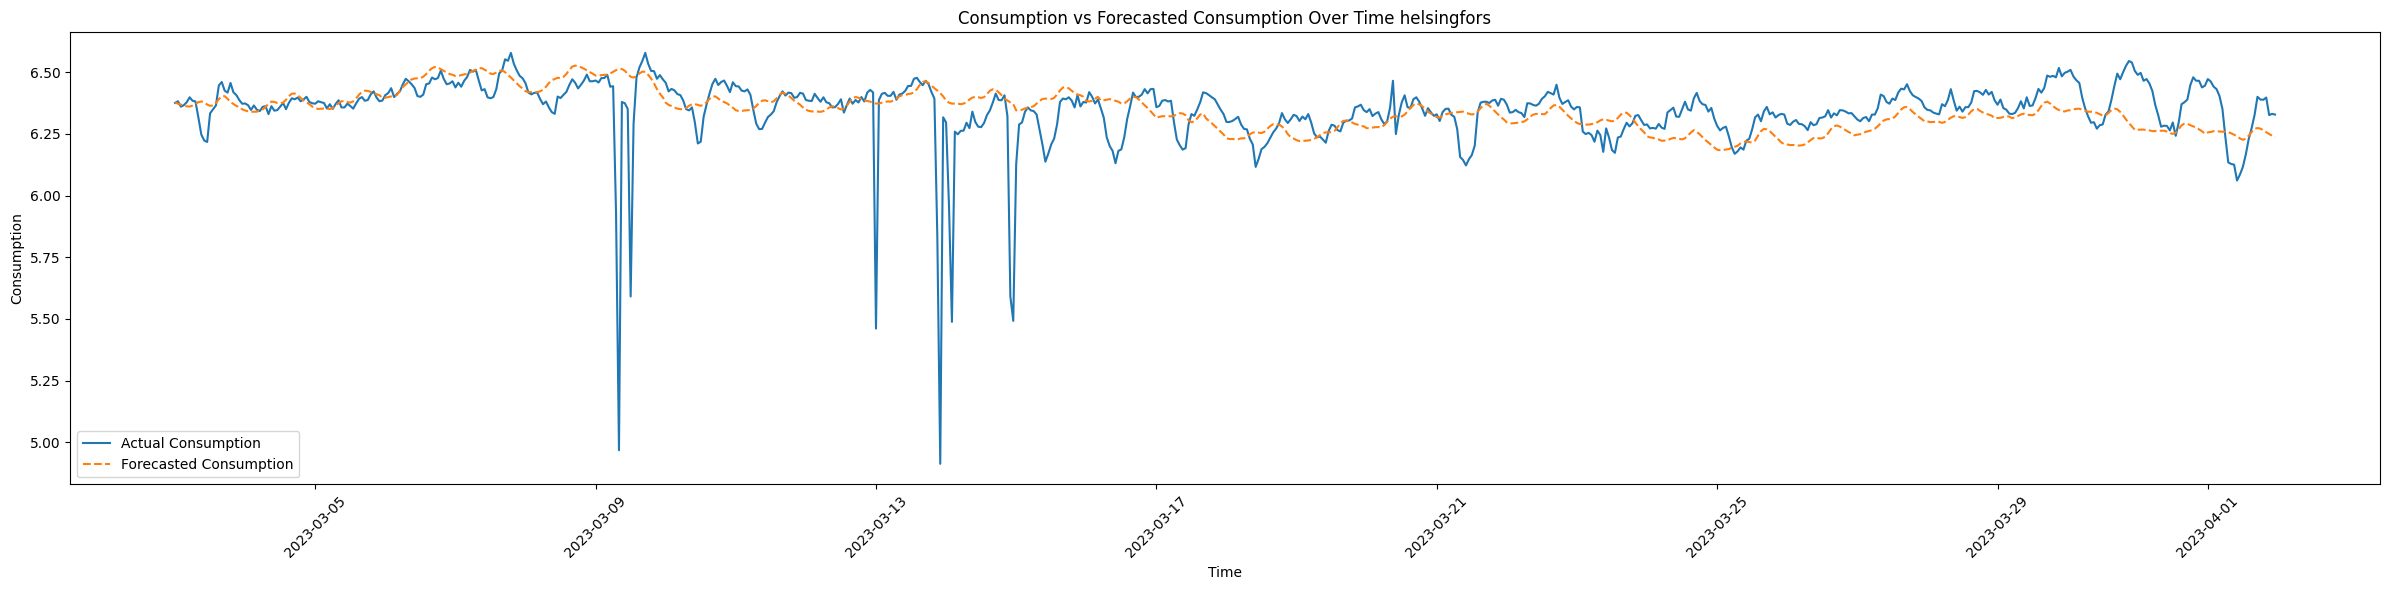

In [52]:
import seaborn as sns
from datetime import datetime, timedelta

for model_output in [return_values[1]]:
    print("Next model")
    for location in model_output[1]["location"].unique():
        print("Location: ", location)

        # Convert 'time' to datetime
        location_data = model_output[1][model_output[1]["location"] == location]
        location_data['time'] = pd.to_datetime(location_data['time'])

        # Invert temperature
        location_data["temperature"] = -1*location_data["temperature"]

        # Plotting
        plt.figure(figsize=(24, 6))
        sns.lineplot(x='time', y='consumption', data=location_data, label='Actual Consumption')
        sns.lineplot(x='time', y='yhat', data=location_data, label='Forecasted Consumption', linestyle='--')

        plt.title(f'Consumption vs Forecasted Consumption Over Time {location}')
        plt.xlabel('Time')
        plt.ylabel('Consumption')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # # Plotting with temperature
        # fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # # Plot consumption and forecast on the primary axis
        # sns.lineplot(x='time', y='consumption', data=location_data, label='Actual Consumption', ax=ax1, color='blue', alpha=0.6)
        # sns.lineplot(x='time', y='yhat', data=location_data, label='Forecasted Consumption', ax=ax1, linestyle='--', color='green')

        # # Create a second y-axis for temperature
        # ax2 = ax1.twinx()
        # sns.lineplot(x='time', y='temperature', data=location_data, label='Temperature', ax=ax2, color='red', linestyle=':')

        # # Setting labels and titles
        # ax1.set_xlabel('Time')
        # ax1.set_ylabel('Consumption', color='blue')
        # ax2.set_ylabel('Inverted Temperature (-1*°C)', color='red')
        # ax1.set_title(f'Consumption, Forecast, and Temperature (Location: {location})')

        # # Handling legends
        # lines_1, labels_1 = ax1.get_legend_handles_labels()
        # lines_2, labels_2 = ax2.get_legend_handles_labels()
        # ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

        # plt.xticks(rotation=45)
        # plt.tight_layout()
        # plt.show()

# Plot forecasts for single days

Next model
Location:  bergen


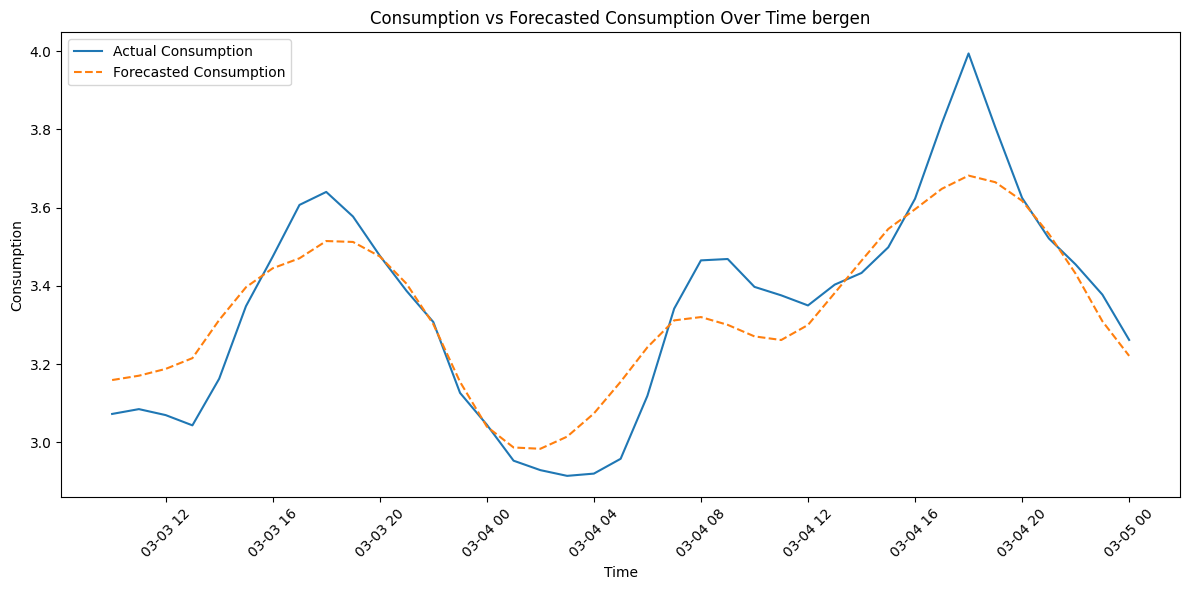

Location:  oslo


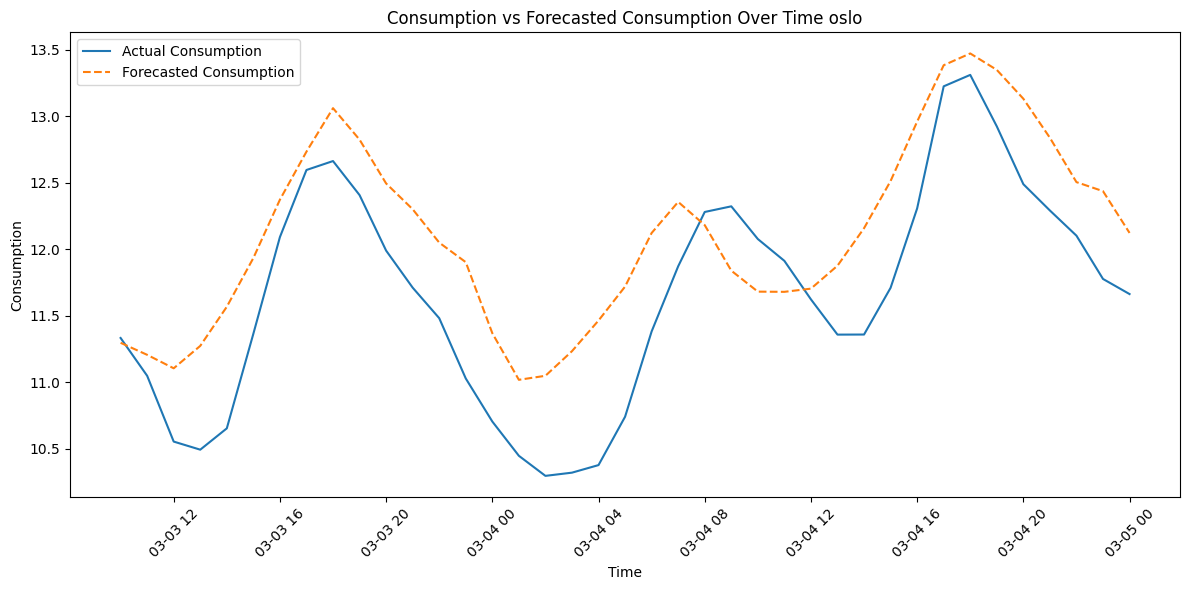

Location:  stavanger


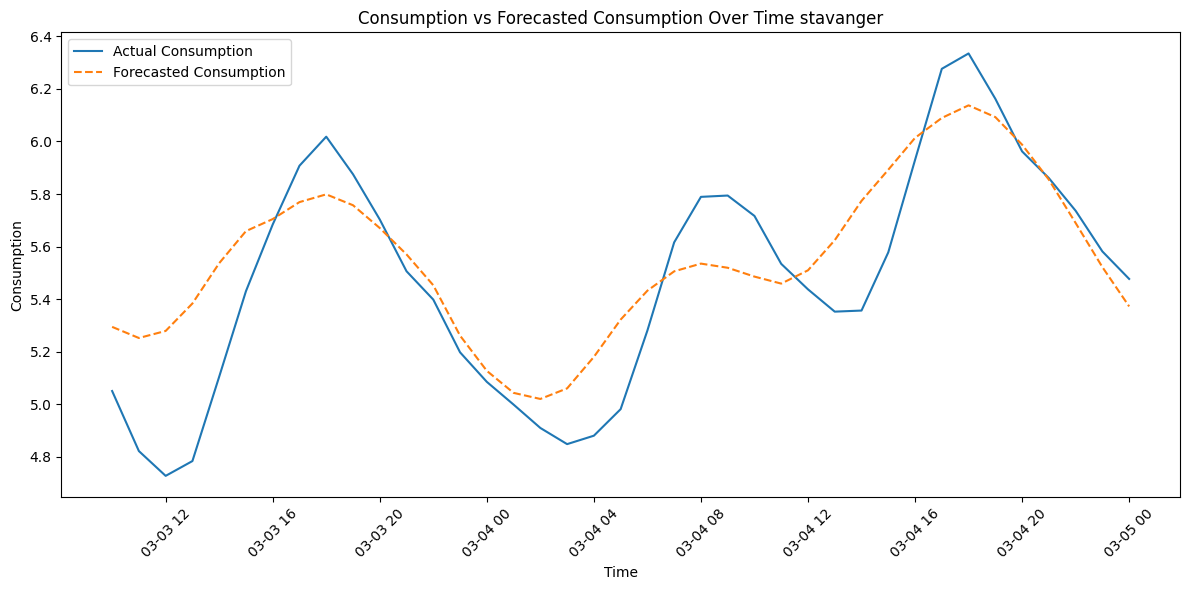

Location:  tromsø


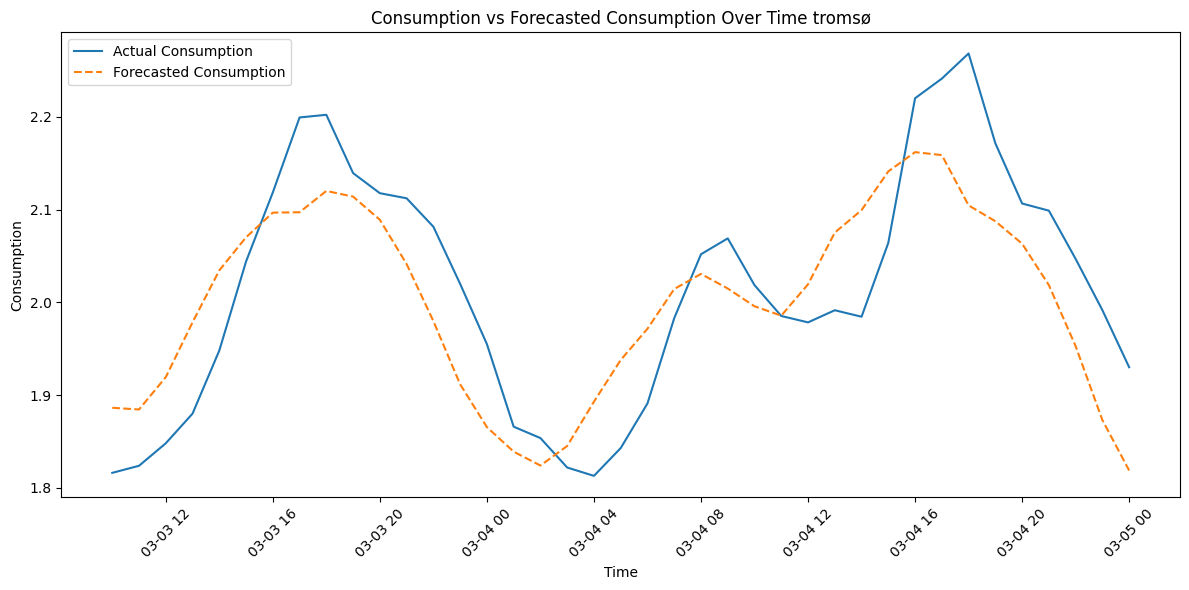

Location:  trondheim


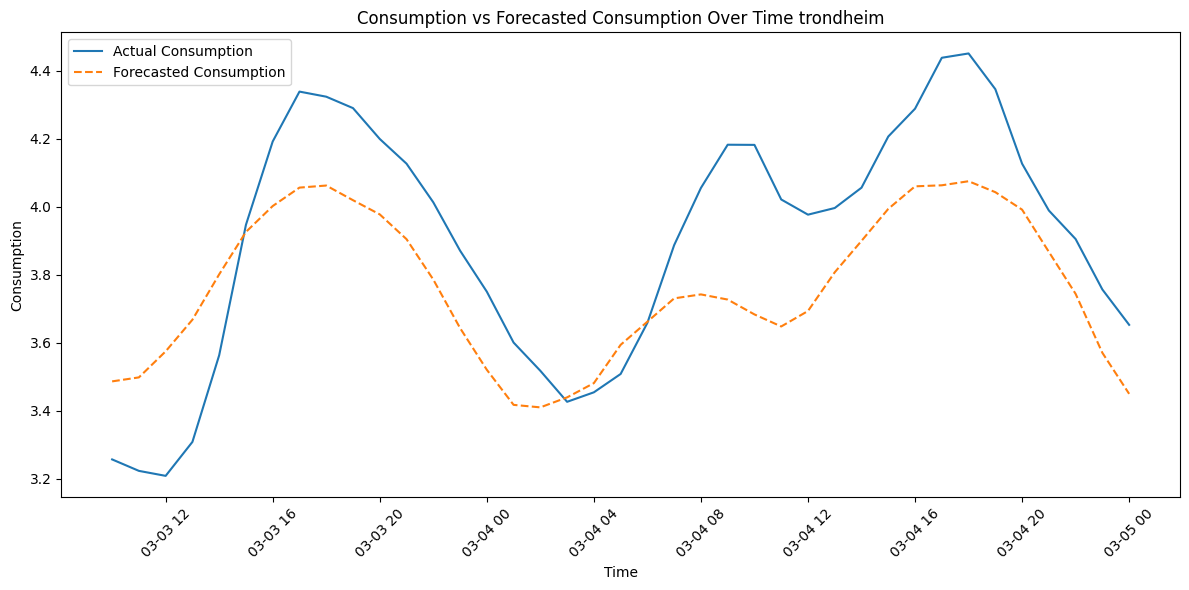

Location:  helsingfors


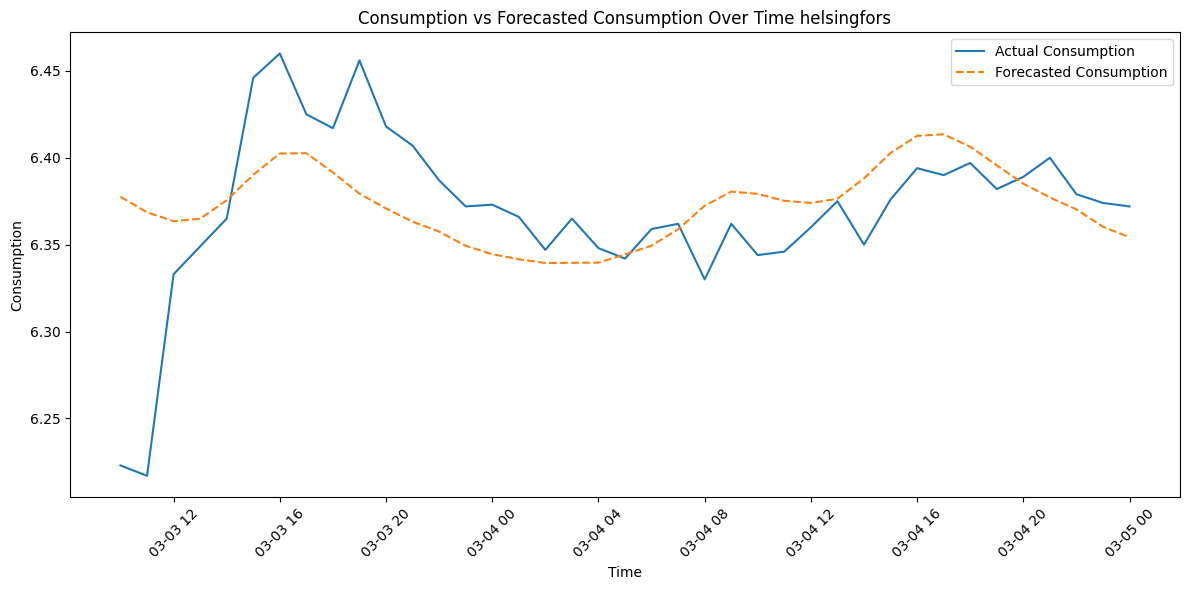

In [61]:
def plot_forecast_sample(df, start_date, location):
    # Calculate the end date (start date + 38 hours)
    end_date = start_date + timedelta(hours=38)

    # Filter the data for the given location and time range
    sample_data = df[(df['location'] == location) & (df['time'] >= start_date) & (df['time'] <= end_date)]


    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='time', y='consumption', data=sample_data, label='Actual Consumption')
    sns.lineplot(x='time', y='yhat', data=sample_data, label='Forecasted Consumption', linestyle='--')

    plt.title(f'Consumption vs Forecasted Consumption Over Time {location}')
    plt.xlabel('Time')
    plt.ylabel('Consumption')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # To include Temperature
    # # Invert temperature
    # sample_data["temperature"] = -1*sample_data["temperature"]

    # # Plotting
    # fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # # Plot consumption and forecast on the primary axis
    # sns.lineplot(x='time', y='consumption', data=sample_data, label='Actual Consumption', ax=ax1, color='blue', alpha=0.6)
    # sns.lineplot(x='time', y='yhat', data=sample_data, label='Forecasted Consumption', ax=ax1, linestyle='--', color='green')

    # # Create a second y-axis for temperature
    # ax2 = ax1.twinx()
    # sns.lineplot(x='time', y='temperature', data=sample_data, label='Temperature', ax=ax2, color='red', linestyle=':')

    # # Setting labels and titles
    # ax1.set_xlabel('Time')
    # ax1.set_ylabel('Consumption', color='blue')
    # ax2.set_ylabel('Inverted Temperature (-1*°C)', color='red')
    # ax1.set_title(f'Consumption, Forecast, and Temperature (Location: {location}, Start: {start_date})')

    # # Handling legends
    # lines_1, labels_1 = ax1.get_legend_handles_labels()
    # lines_2, labels_2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()


for model_output in [return_values[1]]:
    print("Next model")
    for location in model_output[1]["location"].unique():
        print("Location: ", location)

        # Example usage
        start_date = datetime(2023, 3, 3, 10, 0) # March 3, 2023, at 10 AM
        plot_forecast_sample(model_output[1], start_date, location)

# Plot forecast for single days but three at once

ValueError: Could not interpret value `yhat` for `y`. An entry with this name does not appear in `data`.

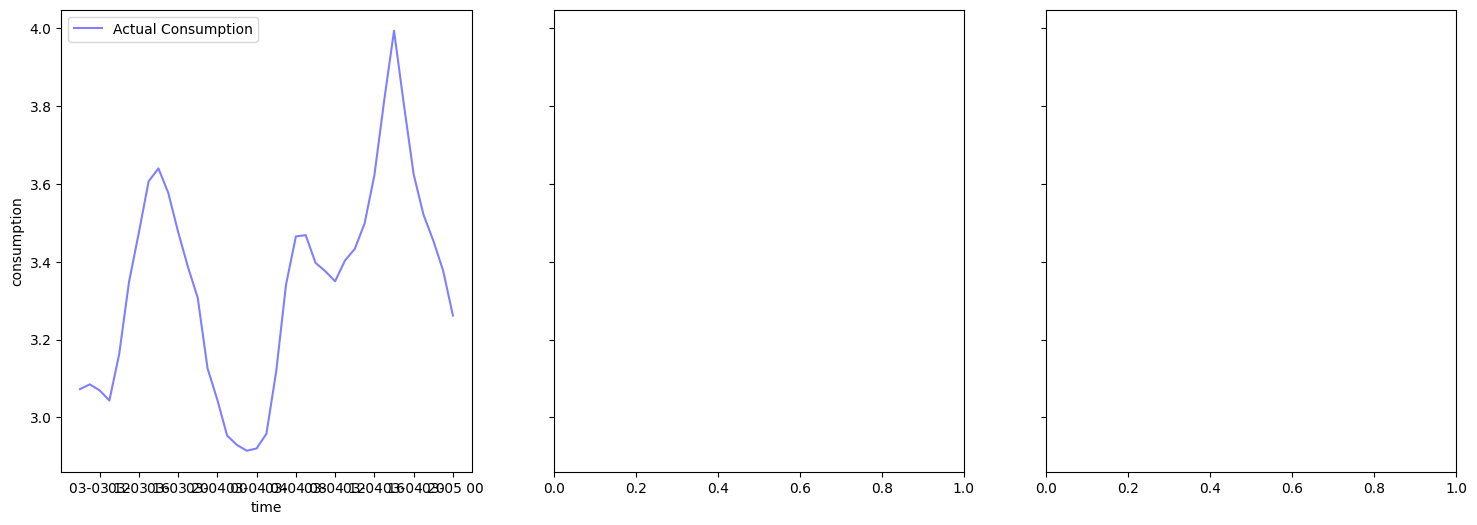

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Assuming df is your DataFrame

# Convert 'time' to datetime if it's not already
df['time'] = pd.to_datetime(df['time'])

def plot_multiple_inverted_temperature_samples(df, start_dates, location, alpha_value=0.5):
    # Number of samples
    num_samples = len(start_dates)

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, num_samples, figsize=(18, 6), sharey=True)

    for i, start_date in enumerate(start_dates):
        # Calculate the end date (start date + 38 hours)
        end_date = start_date + timedelta(hours=38)

        # Filter the data for the given location and time range
        sample_data = df[(df['location'] == location) & (df['time'] >= start_date) & (df['time'] <= end_date)]

        # Select the current subplot
        ax1 = axes[i]

        # Plot consumption and forecast on the primary axis
        sns.lineplot(x='time', y='consumption', data=sample_data, label='Actual Consumption', ax=ax1, color='blue', alpha=alpha_value)
        sns.lineplot(x='time', y='yhat', data=sample_data, label='Forecasted Consumption', ax=ax1, linestyle='--', color='green')

        # Create a second y-axis for inverted temperature
        ax2 = ax1.twinx()

        # Inverting the temperature values
        sample_data['inverted_temperature'] = sample_data['temperature'] * -1

        sns.lineplot(x='time', y='inverted_temperature', data=sample_data, label='Inverted Temperature', ax=ax2, color='red', linestyle=':')

        # Setting labels and titles
        ax1.set_xlabel('Time')
        ax1.set_title(f'Start: {start_date}')

        if i == 0:  # Only set ylabel for the first subplot
            ax1.set_ylabel('Consumption', color='blue')
            ax2.set_ylabel('Inverted Temperature (°C)', color='red')

        ax1.tick_params(axis='x', rotation=45)

    # Adjust layout
    plt.tight_layout()

    # Handling legends for the last subplot
    lines_1, labels_1 = axes[-1].get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.show()

# Example usage
start_dates = [datetime(2023, 3, 3, 10, 0), datetime(2023, 3, 4, 10, 0), datetime(2023, 3, 5, 10, 0)]
plot_multiple_inverted_temperature_samples(df, start_dates, 'bergen', alpha_value=0.5)

In [ ]:
outcpy = out.copy()
outcpy.sort_values('mae', ascending=False, inplace=True)

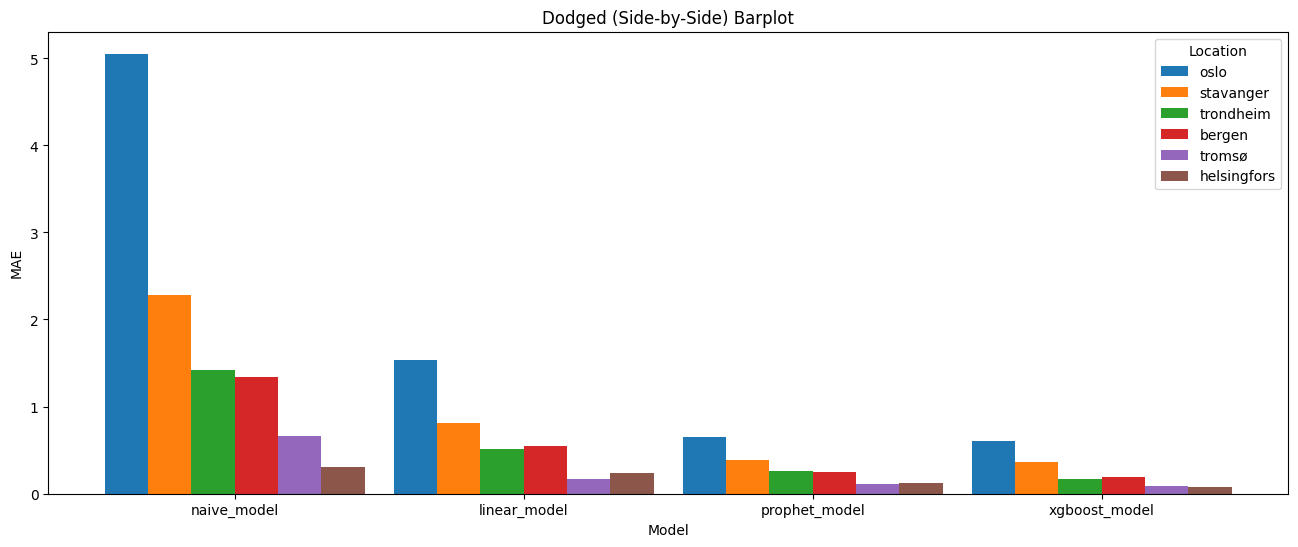

In [ ]:
# Get unique models and locations
models = outcpy['model'].unique()
locations = outcpy['location'].unique()

# Create a dodged (side-by-side) bar plot
fig, ax = plt.subplots(figsize=(16, 6))

bar_width = 0.15
bar_positions = range(len(models))

for i, location in enumerate(locations):
    location_data = outcpy[outcpy['location'] == location]
    x_values = [pos + i * bar_width for pos in bar_positions]
    y_values = location_data['mae']
    
    ax.bar(x_values, y_values, width=bar_width, label=location)

ax.set_xticks([pos + (bar_width * (len(locations) - 1) / 2) for pos in bar_positions])
ax.set_xticklabels(models)
ax.set_xlabel('Model')
ax.set_ylabel('MAE')
ax.set_title('Dodged (Side-by-Side) Barplot')
plt.legend(title='Location')

plt.show()

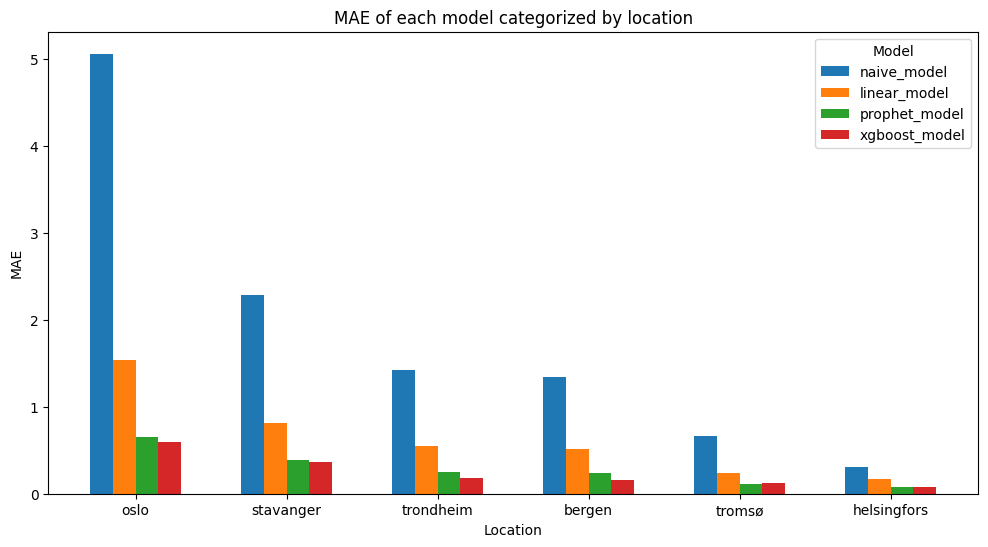

In [ ]:
# Get unique models and locations
models = outcpy['model'].unique()
locations = outcpy['location'].unique()

# Create a dodged (side-by-side) bar plot with 'model' and 'location' switched
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
bar_positions = range(len(locations))

for i, model in enumerate(models):
    model_data = outcpy[outcpy['model'] == model]
    x_values = [pos + i * bar_width for pos in bar_positions]
    y_values = model_data['mae']
    
    ax.bar(x_values, y_values, width=bar_width, label=model)

ax.set_xticks([pos + (bar_width * (len(models) - 1) / 2) for pos in bar_positions])
ax.set_xticklabels(locations)
ax.set_xlabel('Location')
ax.set_ylabel('MAE')
ax.set_title('MAE of each model categorized by location')
plt.legend(title='Model')

plt.show()